Load dataset:

In [1]:
from HumanGenomeDataset.load_dataset import load_dataset

data_df = load_dataset('dna_protein_coding_sequences')
data_df.head(2)

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,ID,sequence,category
0,NM_001368254.1,GCTGAGCTGAGCTGGGGCGCAGCCGCCTGTCTGCACCGGCAGCACC...,NM
1,NM_001350977.1,TCCACAACTGAAACATCCACTTCTGAACACCATGTCCTACTACAGC...,NM


Start simulation:

In [2]:
from src.simulation import ProteinSinthesisProcess
SIM_TIME = 30

In [3]:
protein_synthesis_process = ProteinSinthesisProcess(dna_sequences_df=data_df, verbose=False)
protein_synthesis_process.run(simulation_time=SIM_TIME) # run the simulation

Simulation environment initialized
Simulation started:
Time 0.0000: DNA Sequence 0 requesting to start synthesis
Time 0.0000: DNA Sequence 0 synthesize started
Time 0.1113: DNA Sequence 1 requesting to start synthesis
Time 0.1113: DNA Sequence 1 synthesize started
Time 0.7526: DNA Sequence 2 requesting to start synthesis
Time 0.7526: DNA Sequence 2 synthesize started
Time 0.9057: DNA Sequence 3 requesting to start synthesis
Time 0.9057: DNA Sequence 3 synthesize started
Time 1.8512: DNA Sequence 4 requesting to start synthesis
Time 1.8512: DNA Sequence 4 synthesize started
Time 1.8512: DNA Sequence 4 synthetis ended
Time 2.2016: DNA Sequence 5 requesting to start synthesis
Time 2.2016: DNA Sequence 5 synthesize started
Time 2.2016: DNA Sequence 5 synthetis ended
Time 2.6410: DNA Sequence 6 requesting to start synthesis
Time 2.6410: DNA Sequence 6 synthesize started
Time 2.6410: DNA Sequence 6 synthetis ended
Time 3.1507: DNA Sequence 7 requesting to start synthesis
Time 3.1507: DNA Seq

c:\Users\giuli\anaconda3\lib\site-packages\Bio\Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Time 4.5613: DNA Sequence 9 synthetis ended
Time 4.5613: DNA Sequence 10 synthesize started
Time 4.6613: DNA Sequence 3 synthetis ended
Time 5.0100: DNA Sequence 11 requesting to start synthesis
Time 5.0100: DNA Sequence 11 synthesize started
Time 5.3153: DNA Sequence 12 requesting to start synthesis
Time 5.4769: DNA Sequence 13 requesting to start synthesis
Time 5.7378: DNA Sequence 14 requesting to start synthesis
Time 6.0440: DNA Sequence 15 requesting to start synthesis
Time 6.6116: DNA Sequence 16 requesting to start synthesis
Time 6.9718: DNA Sequence 17 requesting to start synthesis
Time 7.3113: DNA Sequence 7 synthetis ended
Time 7.3113: DNA Sequence 12 synthesize started
Time 7.3113: DNA Sequence 12 synthetis ended
Time 7.3113: DNA Sequence 13 synthesize started
Time 7.3113: DNA Sequence 13 synthetis ended
Time 7.3113: DNA Sequence 14 synthesize started
Time 7.3113: DNA Sequence 14 synthetis ended
Time 7.3113: DNA Sequence 15 synthesize started
Time 7.3113: DNA Sequence 15 syn

Results:

In [4]:
results_df = protein_synthesis_process.dna_sequences_df

In [5]:
results_df.columns

Index(['ID', 'sequence', 'category', 'mrna_sequences', 'polypeptides_chains',
       'polypeptides_chains_ext', 'number_of_proteins_synthesized',
       'protein_synthesized', 'request_start_process_time',
       'start_process_time', 'start_transcription_time',
       'start_translation_time', 'end_translation_time', 'end_process_time'],
      dtype='object')

In [6]:
print('Number of DNA sequence traslated:', results_df[results_df['mrna_sequences'].notna()].shape[0])
print('Number of DNA sequence not traslated:', results_df[results_df['protein_synthesized']==False].shape[0])

Number of DNA sequence traslated: 13
Number of DNA sequence not traslated: 11


In [7]:
results_df[results_df['mrna_sequences'].notna()][[
    'polypeptides_chains', 'number_of_proteins_synthesized']]

,polypeptides_chains,number_of_proteins_synthesized
6807,"[NH2-MSSSFIKRPSLIFRHNITTEV-COOH, NH2-MSSSFIKRP...",3
6832,[NH2-MSQTRHDLTVVVDRPGSYGRLWGVRLHPGCPTGVASPGVSR...,1
13480,[NH2-MRGRHASAPVVTTETSSSEPPYRVSDPLTRAPGRLRWPEMA...,1
21397,[NH2-MDVLDRVRPVPQGGGTRHGRGRSLGGTSHSYSSRCGCHRSR...,2
21454,"[NH2-MSIDPGTSTTSIL-COOH, NH2-MSIDPGTSTTSLL-COO...",4
38095,"[NH2-MQKPRWGLVYYRHKLVFRQSLY-COOH, NH2-MQKPRWGL...",2
49628,"[NH2-MPHSRKD-COOH, NH2-MPHSRKD-COOH, NH2-MPHSR...",4
69870,[NH2-MLGRTSLPGASGLPGPEGPPQVRGAPTSSNFPNICSPSCSF...,4
78446,[NH2-MVVMYGGLGSVPRSRLGVRLPRRDPGGPGRDTLPCLSVVGV...,1
113258,"[NH2-MV-COOH, NH2-MV-COOH]",2


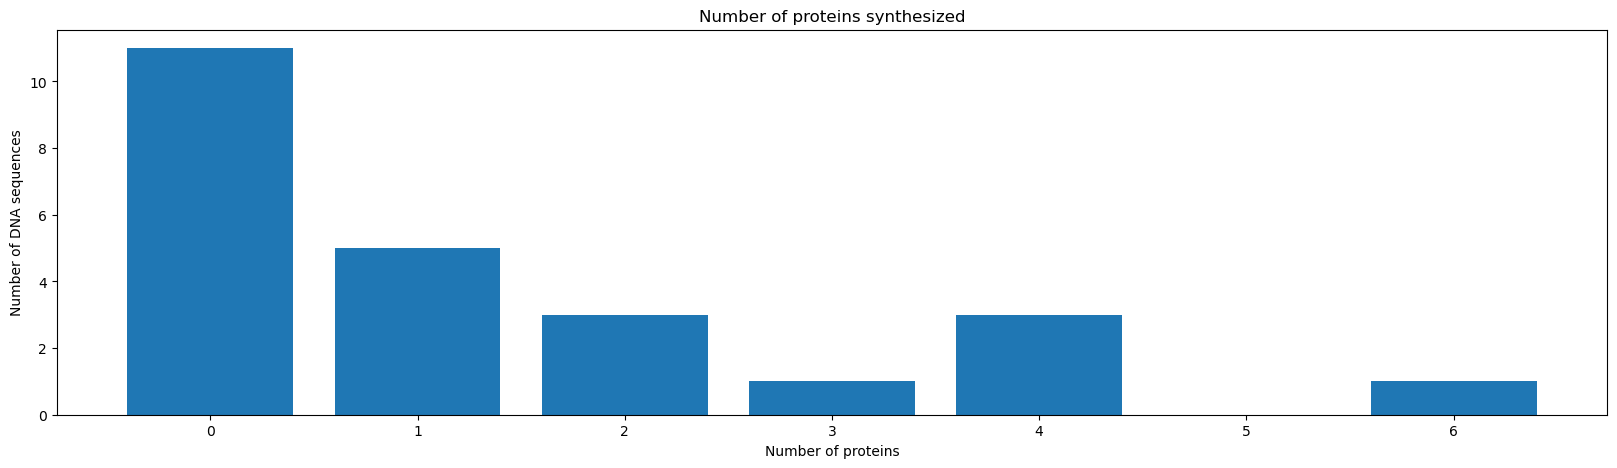

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.bar(results_df['number_of_proteins_synthesized'].value_counts().index,
        results_df['number_of_proteins_synthesized'].value_counts().values)
plt.title('Number of proteins synthesized')
plt.xlabel('Number of proteins')
plt.ylabel('Number of DNA sequences')
plt.show()

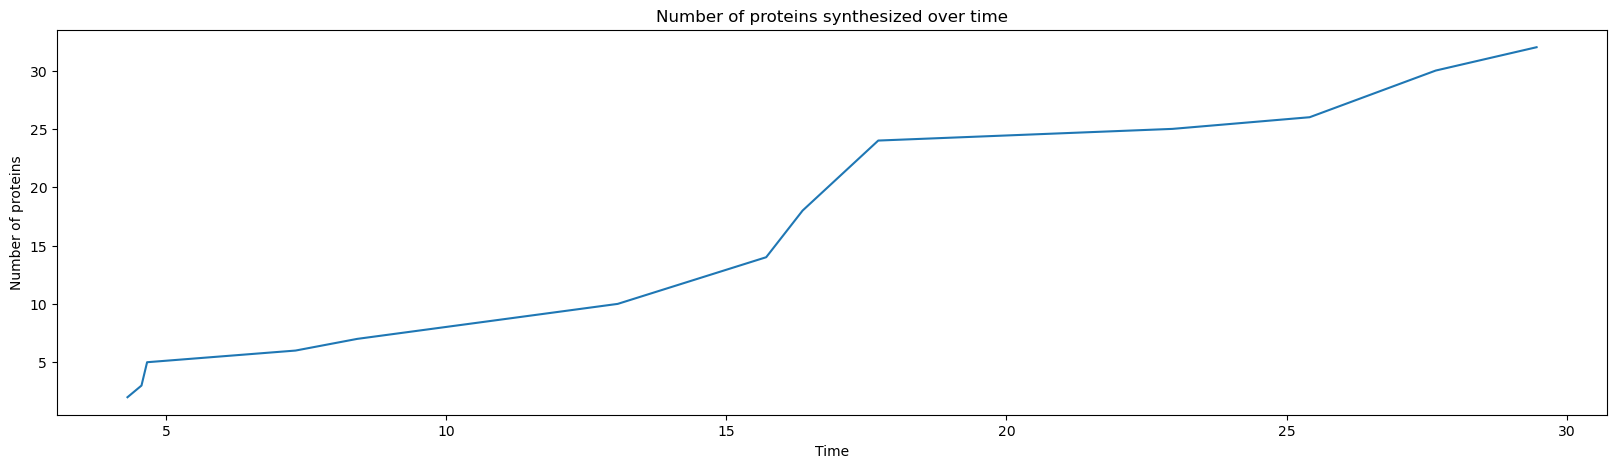

In [9]:
# numero di proteine sintetizzate per ogni istante di tempo
number_of_proteins_synthesized = results_df[results_df['mrna_sequences'].notna()]['number_of_proteins_synthesized']
time = results_df[results_df['mrna_sequences'].notna()]['end_process_time']

# convert float values to integers
number_of_proteins_synthesized = number_of_proteins_synthesized
time = time

# riordina i valori in base al tempo
time, number_of_proteins_synthesized = zip(*sorted(zip(time, number_of_proteins_synthesized)))
cumulative_number_of_proteins_synthesized = [number_of_proteins_synthesized[0]]
for i in range(len(number_of_proteins_synthesized)-1):
    cumulative_number_of_proteins_synthesized.append(
        cumulative_number_of_proteins_synthesized[i]+
        number_of_proteins_synthesized[i+1])

plt.figure(figsize=(20, 5))
plt.plot(time, cumulative_number_of_proteins_synthesized)
plt.title('Number of proteins synthesized over time')
plt.xlabel('Time')
plt.ylabel('Number of proteins')
plt.show()